# COGS 108 - EDA Checkpoint

# Names

- Tyler Le
- Aditya Tomar
- William Lynch
- Michael Mao
- Natalie Quach

<a id='research_question'></a>
# Research Question

Is there a positive correlation between the cost of living and the impact of natural disasters in terms of injuries, casualties, and property damage per capita at the county level? Furthermore, in which state does the impact of natural disasters affect cost of living the most?

# Setup

In [159]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# converting city to county
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from tqdm import tqdm # progress bar for .apply()

# for choropleth
import plotly.express as px

# used for choropleth
from urllib.request import urlopen
import json

# filter extra noise from warnings
import warnings
warnings.filterwarnings('ignore')

# Statmodels & patsy
import patsy
import statsmodels.api as sm

# Make plots just slightly bigger for displaying well in notebook
plt.rcParams['figure.figsize'] = (10, 5)

# Displaying figures as image
from IPython.display import Image

## Clean Table #3 (NRI)

In [160]:
df_nri = pd.read_csv('datasets/cleaned/nri.csv')

# Data Cleaning

**Table #1 (Frequency of Disaster By State):** This dataset was fairly clean in that there were no missing values and each observation contains whether or not a state had a natural disaster event in a certain year. We decided to remove spaces from the column names and to replace them with underscores. Since each column describing a natural disaster contains the count of how many natural disasters of that type, there was little data cleaning needed for this dataset.

**Table #2 (Types of Disasters By State/County):** This dataset was fairly clean. We first focused on extracting the relevant columns, which were "state", "declarationType", "incidentType", "declarationTitle", and "declarationArea". These were the relevant variables since we want each state, the type of natural disaster, and whether it occured on a county level or not. We filtered the dataset to only contain natural disasters that occurred at the county level and standardized the column. We decided to keep the year it happened rather than the exact month and day since in our EDA in the future we would like to explore the natural disaster frequencies by decade. To make future analyses more convienient, we renamed some of the column names. Also, we checked for missing values and found that there were none. 

**Table #3 (National Risk Index):** This dataset was fairly clean. We focused on extracting the relevant columns, such as county, population size, National Risk Index score, and expected annual loss. These variables are important because we would like to compare counties per capita. We also decided to lowercase all the columns and replace spaces with underscores for consistency across all dataframes.

**Table #4 (States with Coastline):** This dataset was fairly clean. Originally, each observation in this dataset contained a state and its associated coast. If the state did not have a coast associated, it had a value "None". To aid with future analyses, such as fitting multiple linear regression models later on, we changed the "coast" column to be binary where 0 means that a state does not have a coast associated with it and 1 means that a state does have a coast associated with it.

**Table #5 (Cost of Living):** This dataset was fairly clean. However, we wanted to look at cost of living as it relates to injuries, casualties, and private property damage broken up by county. Currently, the data we have only shows the cities. We used a geocoder to retrieve the county information. We then made a new column in the dataframe to store counties for each city and rearranged the columns to a favored format.

**Table #6 (Average Climate by County)**
This dataset was very clean. All that we needed to change was remove ID numbers after the state abbreviations and change the column names from "Location ID" to "State", "Location" to "County", and "Value" to "Temperature (F)". 

We plan to merge each of the datasets by either the county or state columns. Additionally, we have datasets containing the number of casualties, number of injuries, and property damage amount per state for the years 2015-2020 that we plan on processing and cleaning after the checkpoint (these datasets are in the "datasets/nat_disast_bystate_deaths_cost” folder).

## Clean Table #1 (Frequency of Disaster By State)

In [161]:
freq_df = pd.read_csv('datasets/natural_disaster_frequencies.csv')

# replace space with underscores in column names
freq_df.columns = freq_df.columns.str.replace(' ', '_')

# check for NaNs
assert(freq_df.isna().sum().sum() == 0)

freq_df

,year,state,drought,flooding,freeze,severe_storm,tropical_cyclone,wildfire,winter_storm
0,1980,AK,0,0,0,0,0,0,0
1,1980,AL,1,0,0,0,0,0,0
2,1980,AR,1,1,0,0,0,0,0
3,1980,AZ,0,0,0,0,0,0,0
4,1980,CA,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
2221,2021,VT,0,0,0,0,0,0,0
2222,2021,WA,1,0,0,0,0,1,1
2223,2021,WI,0,0,0,4,0,0,0
2224,2021,WV,0,0,0,0,1,0,0


## Clean Table #2 (Types of Disaster By State/County)

In [162]:
def standardize_county(str_in):
    try:
        if '(County)' in str_in:
            output = str_in.replace('(County)','')
        else:
            output = None
    except: 
        output = None

    return output


def standardize_year(str_in):
    try:
        output = str_in.split('T')[0]
        output = pd.to_datetime(str_in).year
    except:
        output = None
        
    return output

In [163]:
disaster_type_df = pd.read_csv('datasets/DisasterDeclarationsSummaries.csv')

# select a subset of the columns
wanted_columns = ['state', 'declarationDate','incidentType','declarationTitle','designatedArea']

# rename the columns
disaster_type_df = disaster_type_df[wanted_columns].rename(columns={"declarationDate":"year", "designatedArea": "county", "incidentType":"disaster_type", "declarationTitle":"disaster_declaration"})

# Set "Statewide" to None and strip "(County)" from all counties
disaster_type_df['county'] = disaster_type_df['county'].apply(standardize_county)

# filter dataset to only include non-null 
disaster_type_df = disaster_type_df[~disaster_type_df['county'].isnull()]

# strip year column to only include year
disaster_type_df['year'] = disaster_type_df['year'].apply(standardize_year)

# sort by year
disaster_type_df = disaster_type_df.sort_values('year').reset_index(drop = True)

# check for no NaNs
assert(disaster_type_df.isna().sum().sum() == 0)

disaster_type_df

,state,year,disaster_type,disaster_declaration,county
0,IN,1959,Flood,FLOOD,Clay
1,WA,1964,Flood,HEAVY RAINS & FLOODING,Wahkiakum
2,WA,1964,Flood,HEAVY RAINS & FLOODING,Skamania
3,WA,1964,Flood,HEAVY RAINS & FLOODING,Pierce
4,WA,1964,Flood,HEAVY RAINS & FLOODING,Pacific
...,...,...,...,...,...
55040,WA,2022,Flood,"SEVERE STORMS, STRAIGHT-LINE WINDS, FLOODING, ...",Whatcom
55041,WA,2022,Flood,"SEVERE STORMS, STRAIGHT-LINE WINDS, FLOODING, ...",Clallam
55042,WA,2022,Flood,"SEVERE STORMS, STRAIGHT-LINE WINDS, FLOODING, ...",Skagit
55043,TN,2022,Tornado,"SEVERE STORMS, STRAIGHT-LINE WINDS, AND TORNADOES",Gibson


## Clean Table #3 (NRI)

In [164]:
# Look at the "NRI Data Dictionary in the datasets/NRI_Table_Counties" to see what the cols mean
# EAL = "Expected Annual Lost", quantifies the anticipated economic damage resulting from natural hazards each year. 
# 1-100 scale

df_nri = pd.read_csv('datasets/NRI_Table_Counties/NRI_Table_Counties.csv')

# select a subset of the columns
wanted_cols = ['STATE','STATEABBRV','STATEFIPS','COUNTY','COUNTYFIPS','POPULATION','AREA','RISK_SCORE','RISK_RATNG','EAL_SCORE','EAL_RATNG']
df_nri = df_nri[wanted_cols]

# lowercase all columns
df_nri.columns = df_nri.columns.str.lower()

# rename columns
df_nri = df_nri.rename(columns={"stateabbrv":"state_abbrv", "risk_ratng":"risk_rating" ,"eal_ratng":"eal_rating","statefips":"state_fips","countyfips":"county_fips"})

# we need state and county FIPS information (already included in NRI dataset)
df_nri['state_fips'] = df_nri['state_fips'].apply(lambda x: str(x).zfill(2))
df_nri['county_fips'] = df_nri['county_fips'].apply(lambda x: str(x).zfill(3))
df_nri['fips'] = df_nri['state_fips'] + df_nri['county_fips']

In [165]:
# Need to convert risk/eal rating to values.
df_nri.value_counts('risk_rating')
encoding_dict = {"Very Low": 1, "Relatively Low":2, "Relatively Moderate": 3, "Relatively High": 4, "Very High": 5}

def encode_ratings(str_in):
    return (encoding_dict[str_in])

In [166]:
df_nri['risk_encoded'] = df_nri['risk_rating'].apply(encode_ratings)
df_nri['eal_encoded'] = df_nri['eal_rating'].apply(encode_ratings)

# make sure there are no NaNs
assert(df_nri.isna().sum().sum() == 0)

In [167]:
df_nri.to_csv("datasets/cleaned/nri.csv",index=False)

In [168]:
df_nri.head()

,state,state_abbrv,state_fips,county,county_fips,population,area,risk_score,risk_rating,eal_score,eal_rating,fips,risk_encoded,eal_encoded
0,Kentucky,KY,21,Johnson,115,23356,261.958144,9.281419,Relatively Low,11.921944,Relatively Low,21115,2,2
1,Kentucky,KY,21,Kenton,117,159720,160.213975,10.449057,Relatively Low,16.837131,Relatively Moderate,21117,2,3
2,Kentucky,KY,21,Knott,119,16346,351.517978,10.068395,Relatively Low,10.945913,Relatively Low,21119,2,2
3,Kentucky,KY,21,Knox,121,31883,386.298435,11.858245,Relatively Low,11.983719,Relatively Low,21121,2,2
4,Kentucky,KY,21,Larue,123,14193,261.539564,4.610900,Very Low,7.028611,Very Low,21123,1,1


## Clean Table #4 (States with Coastline)

In [169]:
coastline_df = pd.read_csv('datasets/states_with_coastline.csv')
coastline_df.head()

,State,coast
0,Alabama,Gulf Coast
1,Alaska,Pacific Ocean
2,Arizona,None
3,Arkansas,None
4,California,Pacific Ocean


In [170]:
# check data types for each column
coastline_df.dtypes

State    object
coast    object
dtype: object

In [171]:
coastline_df['coast'].value_counts()

None                                20
Atlantic Ocean                      12
Great Lakes Coast                    7
Pacific Ocean                        5
Gulf Coast                           4
Atlantic Ocean/Great Lakes Coast     1
Atlantic Ocean/Gulf Coast            1
Name: coast, dtype: int64

In [172]:
# check for missing values
coastline_df.isna().sum()

State    0
coast    0
dtype: int64

In [173]:
# Binarize "coast" column. 0 = no coastline, 1 = yes coastline
def clean_coast(coast_val):
    coast_val = coast_val.lower()

    if "none" in coast_val:
        coast_val = coast_val.replace("none", "0")
        output = int(coast_val)
    else:
        output = 1
    
    return output

In [174]:
# test function from above
assert clean_coast('None') == 0
assert clean_coast('Atlantic Ocean') == 1

In [175]:
coastline_df['coast'] = coastline_df['coast'].apply(clean_coast)

In [176]:
coastline_df.head()

,State,coast
0,Alabama,1
1,Alaska,1
2,Arizona,0
3,Arkansas,0
4,California,1


## Clean Table #5 (Cost of Living)
### A lot of it is commented out because we performed the cleaning steps and saved it to datasets/cleaned/col_updated.

In [177]:
df_col = pd.read_csv('datasets/cleaned/col_updated.csv')

In [178]:
df = pd.read_csv('datasets/cost_of_living.csv')
df["city_state"] = df["City"] + ", " + df["State"]
df

,City,State,Cost of Living Index,city_state
0,Abilene,TX,89.1,"Abilene, TX"
1,Adrian,MI,90.5,"Adrian, MI"
2,Akron,OH,89.4,"Akron, OH"
3,Alamogordo,NM,85.8,"Alamogordo, NM"
4,Albany,GA,87.3,"Albany, GA"
...,...,...,...,...
505,Wheeling,WV,84.1,"Wheeling, WV"
506,New London,CT,105.9,"New London, CT"
507,Daphne,AL,96.6,"Daphne, AL"
508,Victoria,TX,89.5,"Victoria, TX"


In [179]:
geolocator = Nominatim(user_agent='find-county')

# extract County from Geocode object 
def standardize_geocode(location):
    try:
        output = [x.strip() for x in location.address.split(',') if 'County' in x ][0]
    except: 
        output = None
        
    return output

In [180]:
# # the result of this is saved to a dataframe already

# # we need this to avoid timeout 
# geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

# # allow for progress bar on .apply()
# tqdm.pandas()

# # convert city_state column to geocode
# try:
#     df['geocode'] = df['city_state'].progress_apply(geocode)
# except:
#     pass

In [181]:
# # convert geocode column to extract the county
# df['county'] = df['geocode'].apply(standardize_geocode)

In [182]:
# # check for nans
# df.isna().sum().sum()

In [183]:
# # remove rows with nans
# df.dropna(how='any')

In [184]:
# # # save resulting df as csv to avoid running previous cells frequently
# # df.to_csv('datasets/col_updated.csv', index=False)
# df.to_csv('datasets/cleaned/col_updated.csv', index=False)
# df

## Clean Table #6

In [185]:
# Dataset for the mean climate for each county in the USA except those in Hawaii. The climate is measured over a 5-year span from 2017-2022. 
climate_df = pd.read_csv('datasets/Average_Climate_By_County.csv')
climate_df['Location ID'] = climate_df['Location ID'].apply([lambda x: x[0:2]])
climate_df = climate_df.rename(columns={'Location ID': 'State', 'Location': 'County', 'Value': 'Temperature (F)'})
climate_df.head()

,State,County,Temperature (F)
0,AL,Autauga County,65.7
1,AL,Baldwin County,68.4
2,AL,Barbour County,66.0
3,AL,Bibb County,63.9
4,AL,Blount County,62.7


# Data Analysis & Results (EDA)

# EDA on Table #3 (risk score vs eal score)

## Distributions

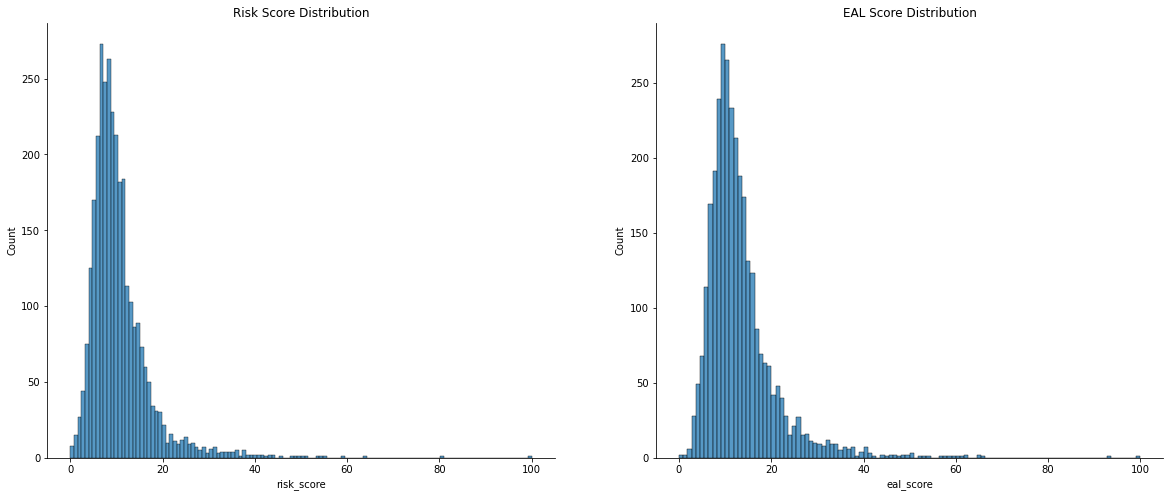

In [186]:
# get distribution of risk/eal score

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))

sns.histplot(x='risk_score', ax = ax1, data = df_nri)
sns.histplot(x='eal_score', ax = ax2, data = df_nri)

ax1.set_title('Risk Score Distribution')
ax2.set_title('EAL Score Distribution')

sns.despine()
plt.show()

In [187]:
df_nri['risk_score'].describe()

count    3142.000000
mean       10.603570
std         6.768475
min         0.000000
25%         6.689240
50%         9.089077
75%        12.533477
max       100.000000
Name: risk_score, dtype: float64

In [188]:
df_nri['eal_score'].describe()

count    3142.000000
mean       13.334561
std         7.736843
min         0.018372
25%         8.799945
50%        11.517427
75%        15.516319
max       100.000000
Name: eal_score, dtype: float64

#### The two distributions are right-skewed, so let's log-transform them.

In [189]:
# we do a log(x + .1) transformation because some x == 0 and we are unable to log those.
df_nri['risk_score_log10'] = np.log10(df_nri['risk_score'] + .1) 
df_nri['eal_score_log10'] = np.log10(df_nri['eal_score'] + .1) 

#### Let's see the log-transformed distributions.

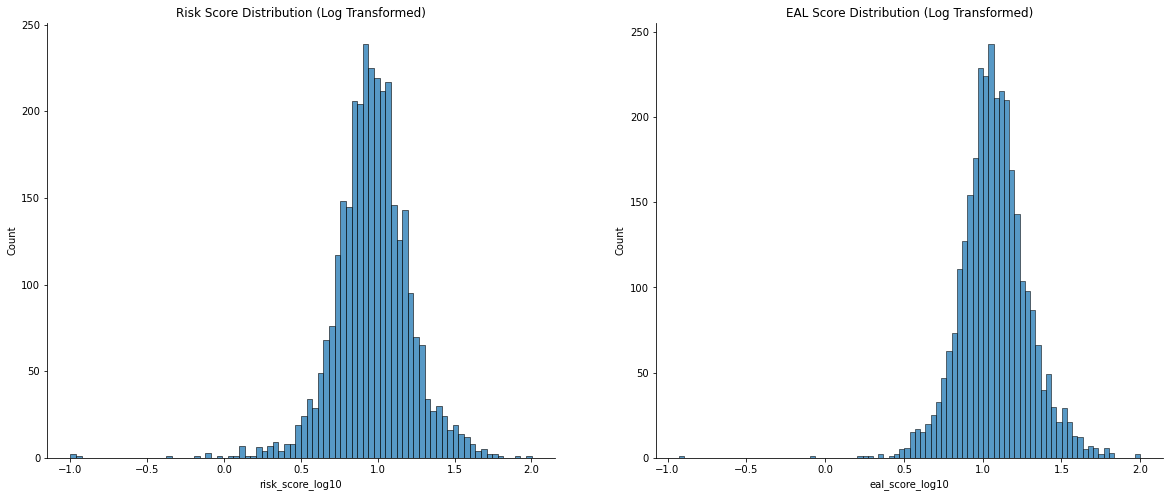

In [190]:
# get distribution of risk/eal score (log-transformed)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))

sns.histplot(x='risk_score_log10', ax = ax1, data = df_nri)
sns.histplot(x='eal_score_log10', ax = ax2, data = df_nri)

ax1.set_title('Risk Score Distribution (Log Transformed)')
ax2.set_title('EAL Score Distribution (Log Transformed)')

sns.despine()
plt.show()

### What's going on at the left-end of our distribution?

In [191]:
df_nri[df_nri['risk_score_log10'] < -.5]

,state,state_abbrv,state_fips,county,county_fips,population,area,risk_score,risk_rating,eal_score,eal_rating,fips,risk_encoded,eal_encoded,risk_score_log10,eal_score_log10
1479,Georgia,GA,13,Chattahoochee,053,11267,248.735663,0.009269,Very Low,4.693806,Very Low,13053,1,1,-0.961504,0.680680
2673,Texas,TX,48,Loving,301,82,668.751593,0.004606,Very Low,0.018372,Very Low,48301,1,1,-0.980444,-0.926753
2902,Virginia,VA,51,Loudoun,107,312311,515.576847,0.000000,Very Low,17.339336,Relatively Moderate,51107,1,3,-1.000000,1.241530


In [192]:
df_nri[df_nri['eal_score_log10'] < -.5]

,state,state_abbrv,state_fips,county,county_fips,population,area,risk_score,risk_rating,eal_score,eal_rating,fips,risk_encoded,eal_encoded,risk_score_log10,eal_score_log10
2673,Texas,TX,48,Loving,301,82,668.751593,0.004606,Very Low,0.018372,Very Low,48301,1,1,-0.980444,-0.926753


### Explanation
In Chattachoochee, GA, the frequency of natural disasters are well below the national average and the area is quite poor where around twenty percent of the population lives below the poverty line. These are among the many factors that contribute to low eal and risk scores.

We can see that Loving, TX is an outlier for both graphs. In fact, Loving, TX is the least populous county in all of the U.S and it consists of flat desert terrain with not much infrastructure. It makes sense that its eal and risk scores are low.  

For Loundon, VA, natural disasters rarely hit the area so its risk score is low. However, it is the richest county in the U.S, so its expected annual loss would be rated higher due to this fact.

### Which counties have the highest and lowest EAL score?

In [193]:
df_nri.sort_values(by = ['eal_score'], ascending = False)

,state,state_abbrv,state_fips,county,county_fips,population,area,risk_score,risk_rating,eal_score,eal_rating,fips,risk_encoded,eal_encoded,risk_score_log10,eal_score_log10
1271,California,CA,06,Los Angeles,037,9818605,4058.076752,100.000000,Very High,100.000000,Very High,06037,5,5,2.000434,2.000434
2623,Texas,TX,48,Harris,201,4092459,1704.918916,80.618536,Very High,93.636473,Very High,48201,5,5,1.906973,1.971909
1295,California,CA,06,Santa Clara,085,1781642,1291.210369,22.951107,Relatively High,66.140195,Very High,06085,4,5,1.362692,1.821122
1285,California,CA,06,Riverside,065,2189641,7206.325086,58.865953,Very High,64.985716,Very High,06065,5,5,1.770601,1.813486
1253,California,CA,06,Alameda,001,1510271,737.476821,40.402820,Relatively High,64.799506,Very High,06001,4,5,1.607485,1.812241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,Michigan,MI,26,Keweenaw,083,2156,540.111622,1.863178,Very Low,1.842344,Very Low,26083,1,1,0.292960,0.288326
1161,Alaska,AK,02,Wrangell,275,2369,2555.846403,2.229517,Very Low,1.743167,Very Low,02275,1,1,0.367266,0.265565
1155,Alaska,AK,02,Prince of Wales-Hyder,198,6172,5219.877753,1.633056,Very Low,1.511835,Very Low,02198,1,1,0.238813,0.207321
1615,Hawaii,HI,15,Kalawao,005,90,11.991403,1.636476,Very Low,0.704283,Very Low,15005,1,1,0.239669,-0.094591


### What counties have the highest and lowest risk score?

In [194]:
df_nri.sort_values(by = ['risk_score'], ascending = False)

,state,state_abbrv,state_fips,county,county_fips,population,area,risk_score,risk_rating,eal_score,eal_rating,fips,risk_encoded,eal_encoded,risk_score_log10,eal_score_log10
1271,California,CA,06,Los Angeles,037,9818605,4058.076752,100.000000,Very High,100.000000,Very High,06037,5,5,2.000434,2.000434
2623,Texas,TX,48,Harris,201,4092459,1704.918916,80.618536,Very High,93.636473,Very High,48201,5,5,1.906973,1.971909
1429,Florida,FL,12,Miami-Dade,086,2496435,1898.662364,63.926384,Very High,46.243703,Very High,12086,5,5,1.806359,1.665991
1285,California,CA,06,Riverside,065,2189641,7206.325086,58.865953,Very High,64.985716,Very High,06065,5,5,1.770601,1.813486
828,New York,NY,36,Bronx,005,1385108,42.050624,55.547136,Very High,25.603947,Relatively Moderate,36005,5,3,1.745443,1.410000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2929,Virginia,VA,51,Falls Church,610,12332,1.985292,0.586229,Very Low,6.946532,Very Low,51610,1,1,-0.163531,0.847975
1329,Colorado,CO,08,Douglas,035,285465,840.184666,0.341317,Very Low,20.669999,Relatively Moderate,08035,1,3,-0.355249,1.317436
1479,Georgia,GA,13,Chattahoochee,053,11267,248.735663,0.009269,Very Low,4.693806,Very Low,13053,1,1,-0.961504,0.680680
2673,Texas,TX,48,Loving,301,82,668.751593,0.004606,Very Low,0.018372,Very Low,48301,1,1,-0.980444,-0.926753


## Linear Regression
#### Before applying linear regression, let's take a look at our correlations and outliers.

<AxesSubplot:xlabel='risk_score', ylabel='eal_score'>

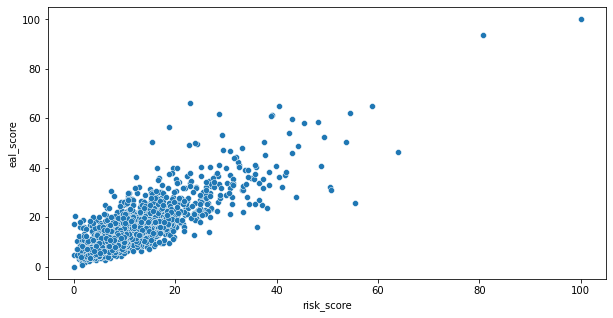

In [195]:
sns.scatterplot(x = 'risk_score', y = 'eal_score', data = df_nri)

### We can see that the most major outliers are the two on the far right. Let's find them.

In [196]:
outliers = df_nri[df_nri['risk_score'] > 80]
outliers

,state,state_abbrv,state_fips,county,county_fips,population,area,risk_score,risk_rating,eal_score,eal_rating,fips,risk_encoded,eal_encoded,risk_score_log10,eal_score_log10
1271,California,CA,06,Los Angeles,037,9818605,4058.076752,100.000000,Very High,100.000000,Very High,06037,5,5,2.000434,2.000434
2623,Texas,TX,48,Harris,201,4092459,1704.918916,80.618536,Very High,93.636473,Very High,48201,5,5,1.906973,1.971909


Los Angeles, CA is the most populous county is the US and Harris, TX is the third most populous county. Both are hit with natural disasters very frequently and both have a lot to lose when those disasters do strike.

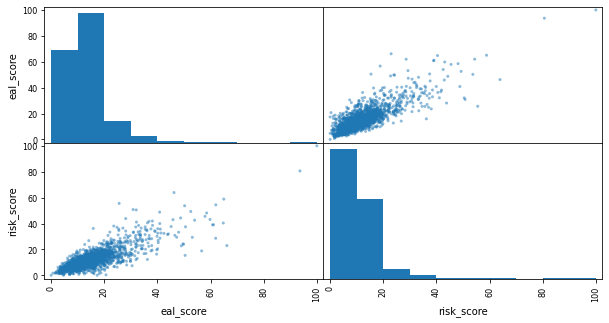

In [197]:
fig = pd.plotting.scatter_matrix(df_nri[['eal_score','risk_score']])

### We can use linear regression to see the correlation between risk_score and expected annual loss.

We will use the log-transformed values.

In [198]:
outcome, predictors = patsy.dmatrices('risk_score_log10 ~ eal_score_log10', df_nri)

mod_log = sm.OLS(outcome, predictors)
res_log = mod_log.fit()
print(res_log.summary())

                            OLS Regression Results                            
Dep. Variable:       risk_score_log10   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.588
Method:                 Least Squares   F-statistic:                     4481.
Date:                Thu, 24 Feb 2022   Prob (F-statistic):               0.00
Time:                        17:02:39   Log-Likelihood:                 1382.7
No. Observations:                3142   AIC:                            -2761.
Df Residuals:                    3140   BIC:                            -2749.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.0255      0.014     

##### By our adjusted r-squared, we can see that there is a correlation between risk and expected annual loss in a county.

## Let's create a choropleth of all counties risk_score in the US

In [199]:
# we need state and county FIPS information (already included in NRI dataset)
df_nri['state_fips'] = df_nri['state_fips'].apply(lambda x: str(x).zfill(2))
df_nri['county_fips'] = df_nri['county_fips'].apply(lambda x: str(x).zfill(3))
df_nri['fips'] = df_nri['state_fips'] + df_nri['county_fips']

with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

### Choropleth for risk score

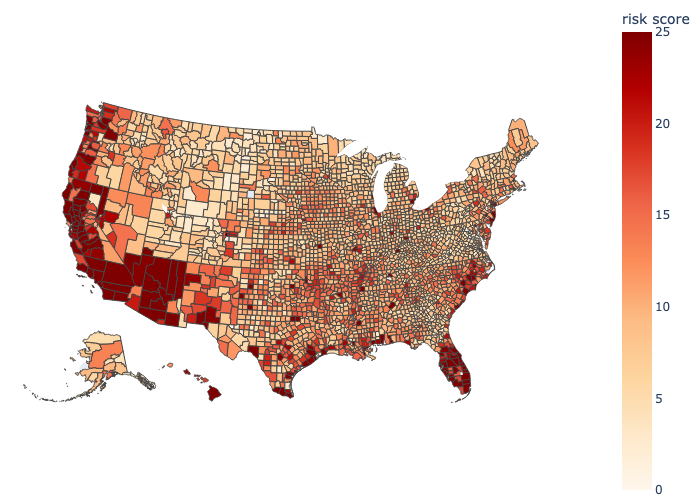

In [200]:
# View the color options below
# https://plotly.com/python/builtin-colorscales/

fig = px.choropleth(df_nri, geojson=counties, locations='fips', color='risk_score',
                           color_continuous_scale="OrRd",
                           range_color=(0, 25),
                           scope="usa",
                           labels={'risk_score':'risk score'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig.write_image("images/risk_choropleth.png")
Image(filename='images/risk_choropleth.png') 


### Choropleth for eal score

In [ ]:
fig = px.choropleth(df_nri, geojson=counties, locations='fips', color='eal_score',
                           color_continuous_scale="Burgyl",
                           range_color=(0, 25),
                           scope="usa",
                           labels={'eal_score':'eal score'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig.write_image("images/eal_choropleth.png")
Image(filename='images/eal_choropleth.png') 